In [2]:
import numpy as np
from numpy import linalg as la
from numpy import *
import numpy.linalg as la

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
import os
import scipy.io as sio

from koopman_pseudospec_qr import KoopPseudoSpecQR
from matplotlib.colors import ListedColormap, BoundaryNorm

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.10.0
GPU is available


In [ ]:
# Load the specified MAT-file using scipy.io.loadmat()
file_path = 'data/pendulum_data/data_pendulum_90.mat'
data_pendulum = loadmat(file_path)

In [ ]:
# Assuming the loaded MAT-file is named data_pendulum_90
X = data_pendulum['DATA_X']
Y = data_pendulum['DATA_Y']

print(X.shape)

In [3]:
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

In [ ]:
### Train the basis using ResKoopNet
### Calculate for chosen number of basis ###
# Results from solver_resdmd_tf
from solver_resdmd import KoopmanNN, KoopmanSolver

dic_size = 300

basis_function = KoopmanNN(layer_sizes=[300,300,300], n_psi_train=dic_size-3) # basis number would be 300

solver = KoopmanSolver(dic=basis_function,
                         target_dim=np.shape(data_x_train)[-1],
                         reg=0.1)
solver.build(data_train=data_train,
             data_valid=data_valid,
             epochs=30,
             batch_size=50000,
             lr=1e-5,
             log_interval=10,
             lr_decay_factor=.8)

# Results from solver_edmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X().numpy()
Psi_Y = solver.get_Psi_Y().numpy()
Koopman_matrix_K = solver.K.numpy()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
}

In [ ]:
## Plot eigenvalues in a unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [10]:
# import os
# import scipy.io as sio

# # Define the folder path
# folder_path = 'data/pendulum_data'
# # Create the folder if it doesn't exist
# os.makedirs(folder_path, exist_ok=True)

# # Save the outputs to a .mat file named according to the number of basis functions, inside the specified folder
# file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis.mat')
# sio.savemat(file_path, outputs)
# print(f'Saved outputs for n_psi_train={N_dict} to {file_path}')

In [4]:
file_path = 'pendulum_90_resdmd_300basis.mat'

data_pendulum = loadmat(file_path)

Psi_X = data_pendulum['Psi_X']
Psi_Y = data_pendulum['Psi_Y']
dic_size = data_pendulum['N_dict'][0]
print(dic_size)

[300]


In [ ]:
## Plot the pseudospectrum
m= Psi_X.shape[0]
print (m)
W = np.ones((m, 1), dtype= np.double)
G= np.dot(Psi_X.T , Psi_X)
print (G.shape)
print ('cond(G) is:',la.cond(G))
x_pts= arange (-1.5, 1.5+0.05, 0.05)
y_pts=x_pts
print (x_pts.shape)
x_pts_mesh,y_pts_mesh= meshgrid (x_pts, y_pts)
z_pts= x_pts_mesh + 1j*y_pts_mesh
z_pts= z_pts.ravel()
RES= KoopPseudoSpecQR(Psi_X,Psi_Y,W,z_pts)
RES= RES.reshape (x_pts_mesh.shape)

lower_bound = 1e-16#; % Example lower bound
#Find indices where the real part of RES is zero
zero_real_indices =nonzero (np.real(RES)==0)
#% Replace only the real part of RES elements that are zero with the lower bound
RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j

62999
(300, 300)
cond(G) is: 3.333361679560518e+20
(61,)


100%|██████████| 3721/3721 [02:39<00:00, 23.33it/s]
C:\Users\xyc93\AppData\Local\Temp\ipykernel_20492\2657340311.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  RES[zero_real_indices] = lower_bound + imag(RES[zero_real_indices]) * 1j


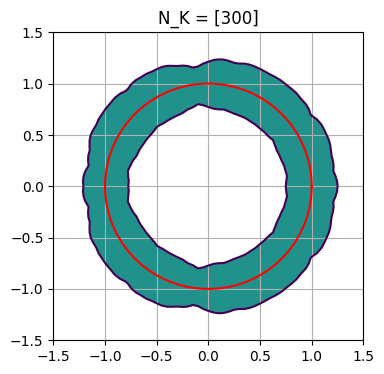

In [5]:
## Plot the pseudospectrum
plt.figure(figsize=(4, 4))  # Set the plot size (width, height) in inches
v= array ([0.25, 1e-64])
plt.contourf(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
plt.contour(x_pts_mesh,y_pts_mesh,log10(1/real(RES)),levels= log10(1/v))
circle_phi= arange (0, 2*np.pi ,2*np.pi/1000 )
plt.plot (np.cos(circle_phi), np.sin(circle_phi), color= 'red')
plt.title(f'N_K = {dic_size}')
plt.grid()
plt.show()

In [ ]:
# ### Calculate for multiple numbers of basis ###

# from solver_resdmd_tf import KoopmanNN, KoopmanSolver
# # from solver_resdmd_2_tf import KoopmanNN, KoopmanSolver

# dic_size = [25,50,100,150,200,250,300] # basis number would be 25, 50, 100, 150, 200, 250, 300

# for n_psi in dic_size:
#     # Initialize the basis function with the current value of n_psi_train
#     basis_function = KoopmanNN(layer_sizes=[300,300,300], n_psi_train=n_psi-3)

#     # Initialize the solver with the basis function and other parameters
#     solver = KoopmanSolver(dic=basis_function,
#                              target_dim=np.shape(data_x_train)[-1],
#                              reg=0.1)
#     # Build the solver with the specified training and validation data
#     solver.build(data_train=data_train,
#                  data_valid=data_valid,
#                  epochs=300,
#                  batch_size=50000,
#                  lr=1e-6,
#                  log_interval=10,
#                  lr_decay_factor=.8)

#     # Assuming the user has these functions or similar ones defined in their environment
#     evalues = solver.eigenvalues.T
#     efuns = solver.eigenfunctions(X)
#     kpm_modes = solver.compute_mode().T
#     N_dict = np.shape(evalues)[0]
#     Koopman_matrix_K = solver.K.numpy()    
#     Psi_X = solver.get_Psi_X().numpy()
#     Psi_Y = solver.get_Psi_Y().numpy()
#     outputs = {
#         'efuns': efuns,
#         'evalues': evalues,
#         'kpm_modes': kpm_modes,
#         'N_dict': N_dict,
#         'K': Koopman_matrix_K,
#         'Psi_X': Psi_X,
#         'Psi_Y': Psi_Y,
#         # 'Psi_X2': Psi_X2,
#         # 'Psi_Y2': Psi_Y2,
#         # "Jacobian": jacobian,  # Uncomment if needed
#         # "Hessian": hessian,    # Uncomment if needed
#     }

#     folder_path = 'data/pendulum_data'  # Adjust the path as needed if you want a different location
#     os.makedirs(folder_path, exist_ok=True)
#     # Save the outputs to a .mat file named according to the number of basis functions, inside the "data" folder
#     file_path = os.path.join(folder_path, f'pendulum_90_resdmd_{N_dict}basis.mat')
#     sio.savemat(file_path, outputs)
#     print(f'Saved outputs for n_psi_train={n_psi} to {file_path}')